# Quantum Volume

In [180]:
from qiskit_experiments.library import QuantumVolume
from qiskit_experiments.framework import BatchExperiment
from qiskit import transpile, execute

from huayi_providers.fake_huayi12 import FakeHuayi12, FakeHuayi12V2
from qiskit_ionq import IonQProvider
from qiskit.providers.fake_provider import *
from qiskit_aer.noise.noise_model import NoiseModel

from qiskit import Aer
from qiskit_aer import AerSimulator

import pandas as pd

fakehuayi = FakeHuayi12V2()
fakemontreal = FakeMontrealV2()

# Each QuantumVolume() is an Experimet class
# The length of tuple() is the circuit depth
exps = [QuantumVolume(tuple(range(i)), trials=100) for i in range(3,12)]

# Batch the experiments (with different depth) into one object
batch_exp = BatchExperiment(exps)
batch_exp.set_transpile_options(optimization_level=3)

# Run with the specified backend
batch_expdata = batch_exp.run(fakemontreal).block_for_results()

# Collect the results in the 'results_table'
results_table = pd.DataFrame()
for i in range(batch_exp.num_experiments):
    qv_result = batch_expdata.child_data(i).analysis_results("quantum_volume")
    data = {'QV': qv_result.value} | {'quality': qv_result.quality} | qv_result.extra
    results_table = pd.concat([results_table, pd.DataFrame(data, index=[i])], ignore_index=True)

display(results_table)
display(batch_expdata.child_data(batch_exp.num_experiments-1).figure(0))

LinAlgError: eig algorithm (geev) did not converge (only eigenvalues with order >= 2 have converged)

,QV,quality,success,confidence,depth,trials
0,8,good,True,0.999999,3,100
1,16,good,True,0.999997,4,100
2,32,good,True,1.000000,5,100
3,64,good,True,0.999999,6,100
4,128,good,True,0.999999,7,100
5,256,good,True,0.999985,8,100
6,512,good,True,0.999979,9,100
7,1024,good,True,0.999823,10,100
8,2048,good,True,0.999664,11,100


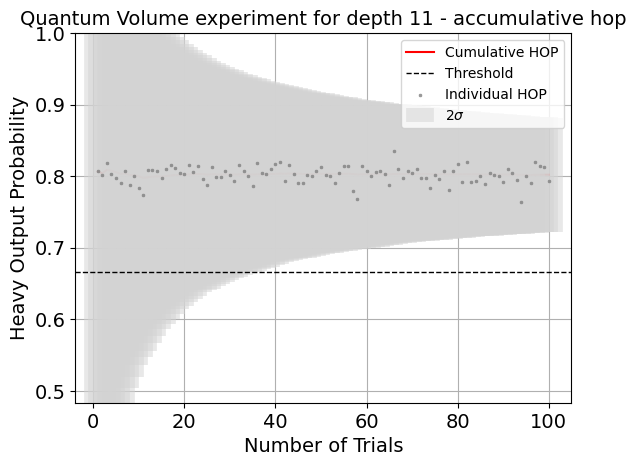

In [179]:
huayi_expdata = batch_expdata
results_table = pd.DataFrame()
for i in range(batch_exp.num_experiments):
    qv_result = huayi_expdata.child_data(i).analysis_results("quantum_volume")
    data = {'QV': qv_result.value} | {'quality': qv_result.quality} | qv_result.extra
    results_table = pd.concat([results_table, pd.DataFrame(data, index=[i])], ignore_index=True)

display(results_table)
display(huayi_expdata.child_data(batch_exp.num_experiments-1).figure(0))